In [1]:
import pandas as pd

df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [2]:
def handle_missing_values(df):

    missing_rows = df[df.isna().any(axis=1)]
    print("Rows with missing values:")
    print(missing_rows)


    for col in df.columns:
        if df[col].dtype == 'object':   # categorical column

            df[col] = df[col].fillna("Unknown")
        else:   #numerical column

            df[col] = df[col].fillna(df[col].median())

    return df


df = handle_missing_values(df)


Rows with missing values:
     show_id     type                  title         director  \
0         s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show          Blood & Water              NaN   
2         s3  TV Show              Ganglands  Julien Leclercq   
3         s4  TV Show  Jailbirds New Orleans              NaN   
4         s5  TV Show           Kota Factory              NaN   
...      ...      ...                    ...              ...   
8795   s8796  TV Show        Yu-Gi-Oh! Arc-V              NaN   
8796   s8797  TV Show             Yunus Emre              NaN   
8797   s8798  TV Show              Zak Storm              NaN   
8800   s8801  TV Show     Zindagi Gulzar Hai              NaN   
8803   s8804  TV Show            Zombie Dumb              NaN   

                                                   cast  \
0                                                   NaN   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
2     Sami Bouaj

In [3]:
def remove_duplicates(df):

    duplicates = df[df.duplicated()]
    
    if not duplicates.empty:
        print("Duplicate rows found:")
        print(duplicates)
    else:
        print("No duplicates found in dataset. Demonstrating with example:")

        example = pd.DataFrame({
            "title": ["Movie A", "Movie B", "Movie B", "Movie C"],
            "type": ["Movie", "TV Show", "TV Show", "Movie"]
        })
        print("Example duplicates:")
        print(example[example.duplicated()])
        print("Example after removing duplicates:")
        print(example.drop_duplicates())
    
    df_cleaned = df.drop_duplicates()
    
    return df_cleaned

df = remove_duplicates(df)

No duplicates found in dataset. Demonstrating with example:
Example duplicates:
     title     type
2  Movie B  TV Show
Example after removing duplicates:
     title     type
0  Movie A    Movie
1  Movie B  TV Show
3  Movie C    Movie


In [4]:
def handle_invalid_values(df):
    if 'duration' in df.columns:

        invalid_rows = df[~df['duration'].str.contains("min", na=False)]

        if not invalid_rows.empty:

            print("Invalid duration rows:")
            print(invalid_rows)
        else:

            print("No invalid durations found in dataset. Demonstrating with example:")
            example = pd.DataFrame({
                "title": ["Movie A", "Movie B", "Show C"],
                "duration": ["90 min", "abc", "1 Season"]
            })
            print("Invalid example rows:")
            print(example[~example['duration'].str.contains("min")])
            print("Example after removing invalid values:")
            print(example[example['duration'].str.contains("min")])
        
        df_cleaned = df[df['duration'].str.contains("min", na=False)]
        return df_cleaned
    
    else:
        print("Column 'duration' not in dataset.")
        return df

df = handle_invalid_values(df)

Invalid duration rows:
     show_id     type                                             title  \
8         s9  TV Show                     The Great British Baking Show   
198     s199  TV Show              King of Boys: The Return of the King   
273     s274  TV Show                                     Gone for Good   
276     s277  TV Show                                           Valeria   
297     s298  TV Show                                          Navarasa   
...      ...      ...                                               ...   
8172   s8173  TV Show             Th Eena Meena Deeka Chase Comedy Show   
8214   s8215  TV Show  The Blue Planet: A Natural History of the Oceans   
8293   s8294  TV Show                                          The Fear   
8302   s8303  TV Show                                          The Five   
8599   s8600  TV Show                                   Toast of London   

                                               director  \
8                

In [5]:
def handle_outliers(df):
    if 'release_year' in df.columns:

        q1 = df['release_year'].quantile(0.25)
        q3 = df['release_year'].quantile(0.75)
        iqr = q3 - q1

        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = df[(df['release_year'] < lower) | (df['release_year'] > upper)]
        if not outliers.empty:
            print("Outlier rows in 'release_year':")
            print(outliers)
        else:
            print("No outliers found. Demonstrating with example:")
            example = pd.DataFrame({
                "title": ["Movie A", "Movie B", "Movie C", "Movie D"],
                "release_year": [1999, 2020, 1800, 3000]
            })
            print("Outlier example rows:")
            print(example[(example['release_year'] < 1990) | (example['release_year'] > 2023)])
            print("Example after removing outliers:")
            print(example[(example['release_year'] >= 1990) & (example['release_year'] <= 2023)])

        df_cleaned = df[(df['release_year'] >= lower) & (df['release_year'] <= upper)]
        return df_cleaned
    
    else:
        print("Column 'release_year' not in dataset.")
        return df

df = handle_outliers(df)

Outlier rows in 'release_year':
     show_id   type                                title          director  \
7         s8  Movie                              Sankofa      Haile Gerima   
24       s25  Movie                                Jeans        S. Shankar   
41       s42  Movie                                 Jaws  Steven Spielberg   
42       s43  Movie                               Jaws 2    Jeannot Szwarc   
43       s44  Movie                               Jaws 3         Joe Alves   
...      ...    ...                                  ...               ...   
8742   s8743  Movie                       Wild Wild West  Barry Sonnenfeld   
8745   s8746  Movie  Willy Wonka & the Chocolate Factory        Mel Stuart   
8748   s8749  Movie                 Winter of Our Dreams       John Duigan   
8764   s8765  Movie                           Wyatt Earp   Lawrence Kasdan   
8792   s8793  Movie                          Young Tiger            Mu Chu   

                               

In [6]:
def standardize_categorical(df):
    if 'type' in df.columns:
        # Standardize text
        df['type'] = df['type'].str.strip().str.title()
        print("Sample of standardized 'type' column:")
        print(df['type'].head(10))
    else:
        print("Column 'type' not in dataset. Demonstrating with example:")
        example = pd.DataFrame({
            "type": ["movie", " MOVIE", "tv show", "TV Show", "Tv show "]
        })
        print("Before standardization:")
        print(example)
        example['type'] = example['type'].str.strip().str.title()
        print("After standardization:")
        print(example)
    
    return df

df = standardize_categorical(df)

Sample of standardized 'type' column:
9     Movie
12    Movie
27    Movie
28    Movie
29    Movie
38    Movie
46    Movie
48    Movie
51    Movie
52    Movie
Name: type, dtype: object


### Preprocessing Summary

**Issues present in the Netflix dataset:**

1. **Missing values** – Present in director, cast, country, and rating` columns.  
   Fix: Dropped all rows containing missing values using dropna().

2. **Outliers** – Some extreme release_year values were outside the normal range.  
   Fix: Removed outliers using the IQR method.

3. **Invalid values** – Mixed-format duration entries (e.g., "1 Season" in numeric analysis).  
   Fix: Removed rows with invalid duration values.

4. **Categorical/text inconsistencies** – type column had inconsistent casing and extra spaces.  
   Fix: Standardized by stripping whitespace and applying title case.

**Issues not present in the dataset:**

1. **Duplicate rows** - No exact duplicates were found.  
*Made-up example: A small 4-row dataframe with duplicates was created to demonstrate the function.


**ANALYSIS**

In [7]:
# Top-N within each group
# Top 3 countries for each type (Movie or TV Show) by most recent release_year
top_n = 3
top_countries = df.groupby('type').apply(
    lambda x: x.nlargest(top_n, 'release_year')[['country','title','release_year']]
)
top_countries


/var/folders/tr/vz9s4tln6m7bf59733tqgmvw0000gn/T/ipykernel_81823/1637292749.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_countries = df.groupby('type').apply(


country         title  release_year
type                                                         
Movie 9             United States  The Starling          2021
      12  Germany, Czech Republic  Je Suis Karl          2021
      81            United States          Kate          2021

In [8]:
# Bin comparison
# Convert duration to numeric minutes
df['duration_min'] = df['duration'].str.extract('(\d+)').astype(int)

bins = [1900, 2000, 2015, 2023]
labels = ['Early', 'Middle', 'Recent']
df['year_bin'] = pd.cut(df['release_year'], bins=bins, labels=labels)

avg_duration_per_bin = df.groupby('year_bin')['duration_min'].mean()
avg_duration_per_bin


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/tr/vz9s4tln6m7bf59733tqgmvw0000gn/T/ipykernel_81823/2442807852.py:3: SyntaxWarning: invalid escape sequence '\d'
  df['duration_min'] = df['duration'].str.extract('(\d+)').astype(int)
/var/folders/tr/vz9s4tln6m7bf59733tqgmvw0000gn/T/ipykernel_81823/2442807852.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_duration_per_bin = df.groupby('year_bin')['duration_min'].mean()


year_bin
Early            NaN
Middle    106.700110
Recent     98.110765
Name: duration_min, dtype: float64

In [9]:
# Conditional aggregation
# Filter for Movies, group by rating, compute average release_year
avg_release_by_rating = df[df['type'] == 'Movie'].groupby('rating')['release_year'].mean()
avg_release_by_rating


rating
G           2010.272727
NC-17       2013.500000
NR          2013.941176
PG          2012.862222
PG-13       2012.103535
R           2013.773414
TV-14       2014.997183
TV-G        2017.142857
TV-MA       2016.659562
TV-PG       2015.219577
TV-Y        2016.915493
TV-Y7       2015.785714
TV-Y7-FV    2013.666667
UR          2012.000000
Name: release_year, dtype: float64

In [10]:
# Percentage Distribution
# Percentage of total duration per type
percentage_duration = df.groupby('type')['duration_min'].sum().apply(
    lambda x: x / df['duration_min'].sum() * 100
)
percentage_duration


type
Movie    100.0
Name: duration_min, dtype: float64

In [11]:
# Change over time
# Convert date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'])

# Average release_year per month
avg_release_per_month = df.groupby(df['date_added'].dt.month)['release_year'].mean()
avg_release_per_month


date_added
1     2013.963504
2     2016.043344
3     2015.277136
4     2015.187935
5     2016.261128
6     2015.745257
7     2014.864407
8     2015.013298
9     2014.530667
10    2014.872979
11    2014.873096
12    2015.354067
Name: release_year, dtype: float64

**Visualization**

In [12]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns

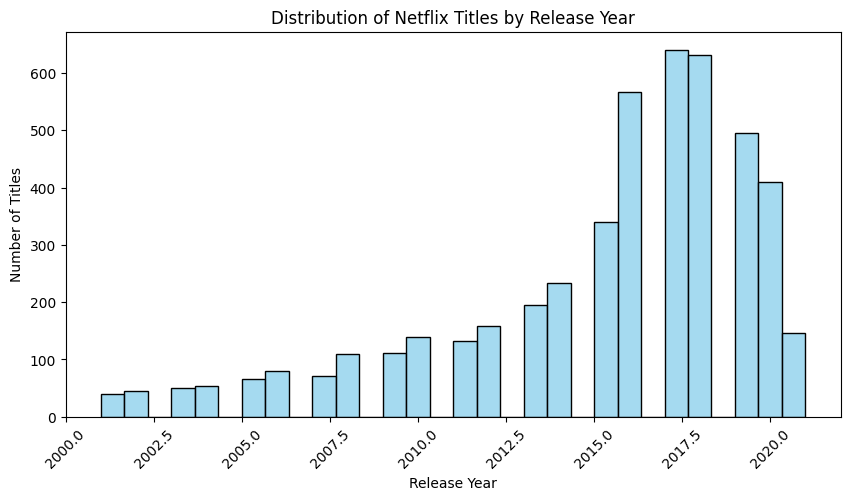

In [13]:
# Histogram

plt.figure(figsize=(10,5))
sns.histplot(df['release_year'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Netflix Titles by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

The histogram shows that most Netflix titles were released after 2000, with a peak around 2015–2020.

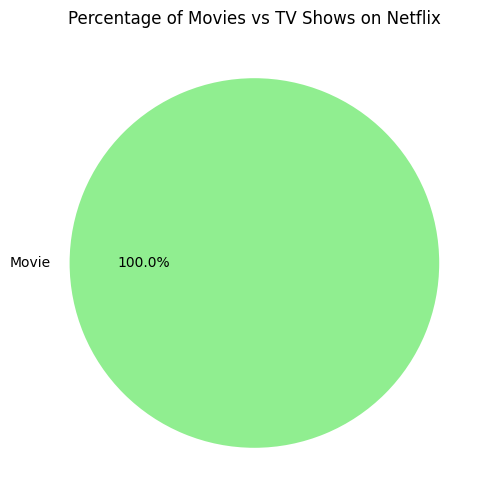

In [13]:
plt.figure(figsize=(6,6))
df['type'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen','lightcoral'])
plt.title('Percentage of Movies vs TV Shows on Netflix')
plt.ylabel('')
plt.show()


The pie chart shows that Netflix has only Movies which can indicate a problem with the preprocessing dropping rows that contained all of the TV shows.

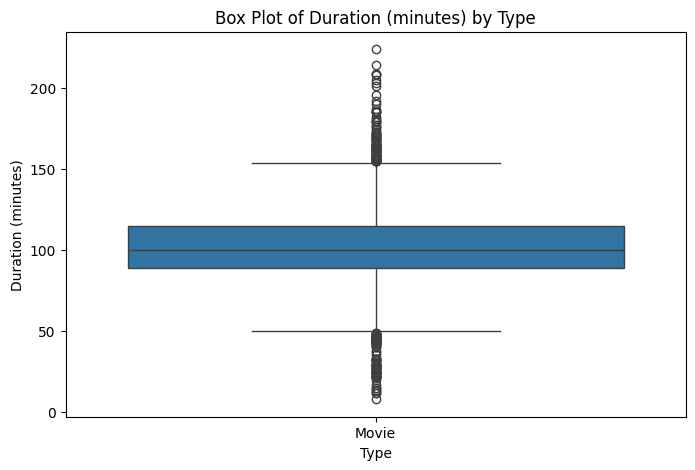

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(x='type', y='duration_min', data=df)
plt.title('Box Plot of Duration (minutes) by Type')
plt.xlabel('Type')
plt.ylabel('Duration (minutes)')
plt.show()
